In [1]:
import os
import cv2
import numpy as np
import keras
from sklearn.model_selection import train_test_split
from keras.applications import VGG16, ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.metrics import Accuracy
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

In [2]:
# Define the path to your dataset directory
dataset_dir = "Dataset"

# Define the subfolders
subfolders = ['Train', 'Test', 'Val']
class_labels = ['CKD', 'Normal']

# Create an empty list to store image paths and labels
all_image_paths = []
labels = []

# Loop through subfolders and class labels to collect image paths
for subfolder in subfolders:
    for class_label in class_labels:
        class_dir = os.path.join(dataset_dir, subfolder, class_label)
        image_paths = [os.path.join(class_dir, f) for f in os.listdir(class_dir)]
        all_image_paths.extend(image_paths)
        labels.extend([class_label] * len(image_paths))

# Shuffle the data and split it into train, validation, and test sets
X = []
for image_path in all_image_paths:
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.resize(image, (128, 128))
        image = image.astype('float32') / 255.0
        X.append(image)

y = np.array(labels)
X = np.array(X)

# Split the data into train, validation, and test sets
random_seed = 42
train_data, temp_data, train_labels, temp_labels = train_test_split(X, y, test_size=0.3, random_state=random_seed)
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=random_seed)

print(f"Training data: {len(train_data)} samples")
print(f"Validation data: {len(validation_data)} samples")
print(f"Testing data: {len(test_data)} samples")

Training data: 5220 samples
Validation data: 1119 samples
Testing data: 1119 samples


In [4]:
from sklearn.preprocessing import LabelEncoder

# Convert string labels to numerical labels
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
validation_labels = label_encoder.transform(validation_labels)

# Check the data types and unique values after conversion
print("Train labels data type:", train_labels.dtype)
print("Validation labels data type:", validation_labels.dtype)
print("Unique train labels:", np.unique(train_labels))
print("Unique validation labels:", np.unique(validation_labels))

Train labels data type: int64
Validation labels data type: int64
Unique train labels: [0 1]
Unique validation labels: [0 1]


In [5]:
# Create a single ImageDataGenerator with data augmentation settings
from keras.applications import MobileNet
from keras.applications import EfficientNetB0
from keras.applications import Xception
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.models import Model
from keras.layers import Dropout
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.regularizers import l2

In [6]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    rescale=1.0 / 255.0,
    validation_split=0.15
)

In [9]:
# Define a function to train a MobileNet model
def train_mobilenet(train_data, train_labels, validation_data, validation_labels):
    
    # Create the base model with pre-trained weights
    base_model = MobileNet(weights='imagenet', include_top=False,input_shape=(128, 128, 3))
    
    # Add global average pooling, dropout, and dense layers to the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.7)(x)
    x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create the MobileNet model
    mobilenet_model = Model(inputs=base_model.input, outputs=output)

    # Compile the model with SGD optimizer, binary crossentropy loss, and accuracy metric
    mobilenet_model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    
    # Train the model using data augmentation and early stopping
    mobilenet_history = mobilenet_model.fit(
        datagen.flow(train_data, train_labels, batch_size=64,subset='training'),
        epochs=10, 
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping]
    )   

    # Evaluate and print the evaluation result for the MobileNet model
    mobilenet_eval_result = mobilenet_model.evaluate(validation_data, validation_labels)
    print(f"Evaluation result for MobileNet: {mobilenet_eval_result}")

    # Return the trained model and training history
    return mobilenet_model, mobilenet_history

# Train the MobileNet model and store the model and history
mobilenet_model, mobilenet_history = train_mobilenet(train_data, train_labels, validation_data, validation_labels)

Epoch 1/10
70/70 [==============================] - 43s 344ms/step - loss: 3.3196 - accuracy: 0.5612 - val_loss: 2.8297 - val_accuracy: 0.7507
Epoch 2/10
70/70 [==============================] - 19s 269ms/step - loss: 3.0850 - accuracy: 0.6423 - val_loss: 2.7975 - val_accuracy: 0.7105
Epoch 3/10
70/70 [==============================] - 19s 263ms/step - loss: 2.9354 - accuracy: 0.7032 - val_loss: 2.8147 - val_accuracy: 0.6953
Epoch 4/10
70/70 [==============================] - 18s 261ms/step - loss: 2.7858 - accuracy: 0.7661 - val_loss: 2.7990 - val_accuracy: 0.6890
Epoch 5/10
70/70 [==============================] - 20s 287ms/step - loss: 2.7100 - accuracy: 0.7913 - val_loss: 2.8260 - val_accuracy: 0.6676
Epoch 6/10
35/35 [==============================] - 1s 19ms/step - loss: 2.8297 - accuracy: 0.7507
Evaluation result for MobileNet: [2.829737663269043, 0.7506702542304993]


In [10]:
from keras.models import save_model

# Save the trained model and its weights to a file
mobilenet_model.save("mobilenet_model.keras")
print("MobileNet model saved successfully")

MobileNet model saved successfully


In [7]:
# Define a function to train a EfficientNet model
def train_efficientnet(train_data, train_labels, validation_data, validation_labels):
    
    # Create the base model with pre-trained weights
    base_model = EfficientNetB0(weights='imagenet', include_top=False,input_shape=(128, 128, 3))
    
    # Add global average pooling, dropout, and dense layers to the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create the EfficientNet model
    efficientnet_model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with SGD optimizer, binary crossentropy loss, and accuracy metric
    efficientnet_model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    
    # Train the model using data augmentation and early stopping
    efficientnet_history = efficientnet_model.fit(
        datagen.flow(train_data, train_labels, batch_size=64,subset='training'),
        epochs=10, 
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping]
     )
    
    # Evaluate and print the evaluation result for the EfficientNet model
    efficientnet_eval_result = efficientnet_model.evaluate(validation_data, validation_labels)
    print(f"Evaluation result for EfficientNet: {efficientnet_eval_result}")
    
    # Return the trained model and training history
    return efficientnet_model, efficientnet_history

# Train the EfficientNet model and store the model and history
efficientnet_model, efficientnet_history = train_efficientnet(train_data, train_labels, validation_data, validation_labels)

Epoch 1/10
70/70 [==============================] - 57s 388ms/step - loss: 3.4678 - accuracy: 0.4997 - val_loss: 3.0235 - val_accuracy: 0.4969
Epoch 2/10
70/70 [==============================] - 19s 270ms/step - loss: 3.4002 - accuracy: 0.5132 - val_loss: 3.0557 - val_accuracy: 0.4933
Epoch 3/10
70/70 [==============================] - 19s 268ms/step - loss: 3.3871 - accuracy: 0.5166 - val_loss: 3.1185 - val_accuracy: 0.4933
Epoch 4/10
70/70 [==============================] - 18s 261ms/step - loss: 3.3717 - accuracy: 0.5172 - val_loss: 2.9945 - val_accuracy: 0.5576
Epoch 5/10
70/70 [==============================] - 20s 290ms/step - loss: 3.3068 - accuracy: 0.5281 - val_loss: 163.7626 - val_accuracy: 0.4933
Epoch 6/10
70/70 [==============================] - 20s 286ms/step - loss: 3.2252 - accuracy: 0.5713 - val_loss: 3.1341 - val_accuracy: 0.4370
Epoch 7/10
70/70 [==============================] - 20s 281ms/step - loss: 3.0831 - accuracy: 0.6369 - val_loss: 3.7460 - val_accuracy: 0.50

In [8]:
from keras.models import save_model

# Save the trained model and its weights to a file
efficientnet_model.save("efficientnet_model.keras")
print("Efficientnet model saved successfully")

Efficientnet model saved successfully


In [6]:
#Define a function to train an Xception model
def train_xception(train_data, train_labels, validation_data, validation_labels):
    
    #Create the base model with pre-trained weights
    base_model = Xception(weights='imagenet', include_top=False,input_shape=(128, 128, 3))
    
    #Add global average pooling, dropout, and dense layers to the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create the Xception model
    xception_model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with SGD optimizer, binary crossentropy loss, and accuracy metric
    xception_model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
    
    # Train the model using data augmentation and early stopping
    xception_history = xception_model.fit(
        datagen.flow(train_data, train_labels, batch_size=64,subset='training'),
        epochs=10, 
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping]
    )
    
    # Evaluate and print the evaluation result for the Xception model
    xception_eval_result = xception_model.evaluate(validation_data, validation_labels)
    print(f"Evaluation result for Xception: {xception_eval_result}")
    
    # Return the trained model and training history
    return xception_model, xception_history

# Train the Xception model and store the model and history
xception_model, xception_history = train_xception(train_data, train_labels, validation_data, validation_labels)

Epoch 1/10
70/70 [==============================] - 57s 446ms/step - loss: 3.4151 - accuracy: 0.5172 - val_loss: 3.0867 - val_accuracy: 0.6193
Epoch 2/10
70/70 [==============================] - 25s 351ms/step - loss: 3.2080 - accuracy: 0.5898 - val_loss: 3.1013 - val_accuracy: 0.6265
Epoch 3/10
70/70 [==============================] - 25s 352ms/step - loss: 3.1094 - accuracy: 0.6435 - val_loss: 3.2135 - val_accuracy: 0.5567
Epoch 4/10
70/70 [==============================] - 26s 366ms/step - loss: 3.0507 - accuracy: 0.6660 - val_loss: 3.1650 - val_accuracy: 0.4906
Epoch 5/10
70/70 [==============================] - 27s 377ms/step - loss: 2.9622 - accuracy: 0.7176 - val_loss: 5.0757 - val_accuracy: 0.6229
Epoch 6/10
70/70 [==============================] - 27s 383ms/step - loss: 2.8970 - accuracy: 0.7496 - val_loss: 32.0319 - val_accuracy: 0.5451
Epoch 7/10
35/35 [==============================] - 2s 48ms/step - loss: 3.1013 - accuracy: 0.6265
Evaluation result for Xception: [3.1012694

In [7]:
from keras.models import save_model

# Save the trained model and its weights to a file
xception_model.save("xception_model.keras")
print("Xception model saved successfully")

Xception model saved successfully


In [6]:
# Define a function to train a Depthwise Separable ResNet model
def train_depthwise_separable_resnet(train_data, train_labels, validation_data, validation_labels):
    
    # Create the base model with pre-trained weights
    base_model = ResNet50(weights='imagenet', include_top=False,input_shape=(128, 128, 3))
    
    # Add global average pooling, dropout, and dense layers to the base model
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.7)(x)
    x = Dense(128, activation='relu',kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.7)(x)
    output = Dense(1, activation='sigmoid')(x)
    
    # Create the Depthwise Separable ResNet model
    depthwise_separable_resnet_model = Model(inputs=base_model.input, outputs=output)
    
    # Compile the model with SGD optimizer, binary crossentropy loss, and accuracy metric
    depthwise_separable_resnet_model.compile(optimizer=SGD(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

    # Define early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    
    # Train the model using data augmentation and early stopping
    depthwise_separable_resnet_history = depthwise_separable_resnet_model.fit(
        datagen.flow(train_data, train_labels, batch_size=64,subset='training'),
        epochs=10, 
        validation_data=(validation_data, validation_labels),
        callbacks=[early_stopping]
    )
    
    # Evaluate and print the evaluation result for the Depthwise Separable ResNet model
    depthwise_separable_resnet_eval_result = depthwise_separable_resnet_model.evaluate(validation_data, validation_labels)
    print(f"Evaluation result for Depthwise Separable ResNet: {depthwise_separable_resnet_eval_result}")
    
    # Return the trained model and training history
    return depthwise_separable_resnet_model, depthwise_separable_resnet_history

# Train the Depthwise Separable ResNet model and store the model and history
depthwise_separable_resnet_model, depthwise_separable_resnet_history = train_depthwise_separable_resnet(train_data, train_labels, validation_data, validation_labels)

Epoch 1/10
70/70 [==============================] - 53s 378ms/step - loss: 3.3812 - accuracy: 0.5918 - val_loss: 3.1964 - val_accuracy: 0.4933
Epoch 2/10
70/70 [==============================] - 20s 282ms/step - loss: 3.1127 - accuracy: 0.6937 - val_loss: 3.4075 - val_accuracy: 0.4933
Epoch 3/10
70/70 [==============================] - 20s 283ms/step - loss: 2.9257 - accuracy: 0.7762 - val_loss: 3.4462 - val_accuracy: 0.4933
Epoch 4/10
70/70 [==============================] - 20s 285ms/step - loss: 2.8061 - accuracy: 0.8283 - val_loss: 3.6825 - val_accuracy: 0.4933
Epoch 5/10
70/70 [==============================] - 21s 299ms/step - loss: 2.7244 - accuracy: 0.8594 - val_loss: 3.7472 - val_accuracy: 0.4933
Epoch 6/10
35/35 [==============================] - 1s 40ms/step - loss: 3.1964 - accuracy: 0.4933
Evaluation result for Depthwise Separable ResNet: [3.1964027881622314, 0.4932975769042969]


In [7]:
from keras.models import save_model

# Save the trained model and its weights to a file
depthwise_separable_resnet_model.save("depthwise_separable_resnet_model.keras")
print("Resnet model saved successfully")

Resnet model saved successfully


In [10]:
from keras.models import load_model

# Load the trained models
mobilenet_model = load_model("mobilenet_model.keras")
efficientnet_model = load_model("efficientnet_model.keras")
xception_model = load_model("xception_model.keras")
depthwise_separable_resnet_model = load_model("depthwise_separable_resnet_model.keras")

# Convert test labels to numerical labels using LabelEncoder
test_labels = label_encoder.transform(test_labels)

# Convert test_data and test_labels to NumPy arrays
test_data = np.array(test_data)
test_labels = np.array(test_labels)

# Evaluate each model on the test data
mobilenet_accuracy = mobilenet_model.evaluate(test_data, test_labels)[1]
efficientnet_accuracy = efficientnet_model.evaluate(test_data, test_labels)[1]
xception_accuracy = xception_model.evaluate(test_data, test_labels)[1]
depthwise_separable_resnet_accuracy = depthwise_separable_resnet_model.evaluate(test_data, test_labels)[1]

# Print the accuracies
print("MobileNet Accuracy:", mobilenet_accuracy)
print("EfficientNet Accuracy:", efficientnet_accuracy)
print("Xception Accuracy:", xception_accuracy)
print("Depthwise Separable ResNet Accuracy:", depthwise_separable_resnet_accuracy)

NameError: name 'label_encoder' is not defined

In [11]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate each model on the test data
mobilenet_predictions = mobilenet_model.predict(test_data)
efficientnet_predictions = efficientnet_model.predict(test_data)
xception_predictions = xception_model.predict(test_data)
depthwise_separable_resnet_predictions = depthwise_separable_resnet_model.predict(test_data)

# Convert predictions to binary labels (0 or 1)
mobilenet_predictions = np.round(mobilenet_predictions)
efficientnet_predictions = np.round(efficientnet_predictions)
xception_predictions = np.round(xception_predictions)
depthwise_separable_resnet_predictions = np.round(depthwise_separable_resnet_predictions)

# Evaluate and print classification reports
mobilenet_report = classification_report(test_labels, mobilenet_predictions, target_names=class_labels)
efficientnet_report = classification_report(test_labels, efficientnet_predictions, target_names=class_labels)
xception_report = classification_report(test_labels, xception_predictions, target_names=class_labels)
depthwise_separable_resnet_report = classification_report(test_labels, depthwise_separable_resnet_predictions, target_names=class_labels)

# Evaluate and print confusion matrices
mobilenet_cm = confusion_matrix(test_labels, mobilenet_predictions)
efficientnet_cm = confusion_matrix(test_labels, efficientnet_predictions)
xception_cm = confusion_matrix(test_labels, xception_predictions)
depthwise_separable_resnet_cm = confusion_matrix(test_labels, depthwise_separable_resnet_predictions)

# Print classification reports
print("MobileNet Classification Report:\n", mobilenet_report)
print("EfficientNet Classification Report:\n", efficientnet_report)
print("Xception Classification Report:\n", xception_report)
print("Depthwise Separable ResNet Classification Report:\n", depthwise_separable_resnet_report)

# Print confusion matrices
print("MobileNet Confusion Matrix:\n", mobilenet_cm)
print("EfficientNet Confusion Matrix:\n", efficientnet_cm)
print("Xception Confusion Matrix:\n", xception_cm)
print("Depthwise Separable ResNet Confusion Matrix:\n", depthwise_separable_resnet_cm)

35/35 [==============================] - 3s 39ms/step
MobileNet Classification Report:
               precision    recall  f1-score   support

         CKD       0.74      0.84      0.79       581
      Normal       0.80      0.68      0.74       538

    accuracy                           0.77      1119
   macro avg       0.77      0.76      0.76      1119
weighted avg       0.77      0.77      0.76      1119

EfficientNet Classification Report:
               precision    recall  f1-score   support

         CKD       0.56      0.42      0.48       581
      Normal       0.51      0.64      0.56       538

    accuracy                           0.53      1119
   macro avg       0.53      0.53      0.52      1119
weighted avg       0.53      0.53      0.52      1119

Xception Classification Report:
               precision    recall  f1-score   support

         CKD       0.79      0.37      0.51       581
      Normal       0.57      0.89      0.69       538

    accuracy            

/home/kavindu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavindu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavindu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/home/kavindu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavindu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kavindu/miniconda3/envs/tf/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/

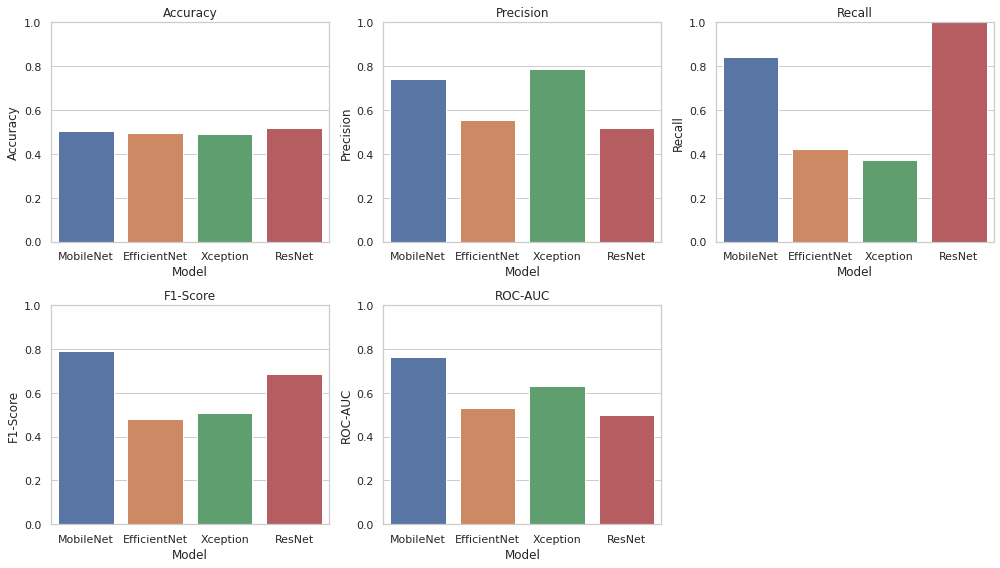

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Assuming you have already loaded the test data and labels as described earlier

# List of model names
model_names = ["MobileNet", "EfficientNet", "Xception", "ResNet"]

# List of model predictions
predictions = [mobilenet_predictions, efficientnet_predictions, xception_predictions, depthwise_separable_resnet_predictions]

# Initialize lists to store evaluation metrics
accuracies = []
precisions = []
recalls = []
f1_scores = []
roc_aucs = []  # New list for ROC-AUC scores

# Calculate evaluation metrics and ROC-AUC for each model
for prediction in predictions:
    accuracy = np.mean(prediction == test_labels)
    accuracies.append(accuracy)
    
    report = classification_report(test_labels, np.round(prediction), target_names=class_labels, output_dict=True)
    precisions.append(report[class_labels[0]]['precision'])
    recalls.append(report[class_labels[0]]['recall'])
    f1_scores.append(report[class_labels[0]]['f1-score'])
    
    # Calculate ROC curve and ROC-AUC
    fpr, tpr, _ = roc_curve(test_labels, prediction)
    roc_auc = auc(fpr, tpr)
    roc_aucs.append(roc_auc)

# Create a DataFrame for visualization
import pandas as pd

data = {
    "Model": model_names,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-Score": f1_scores,
    "ROC-AUC": roc_aucs  # Add ROC-AUC to the DataFrame
}

df = pd.DataFrame(data)

# Plot the evaluation metrics and ROC-AUC
sns.set(style="whitegrid")
plt.figure(figsize=(14, 8))

# Accuracy Plot
plt.subplot(2, 3, 1)
sns.barplot(x="Model", y="Accuracy", data=df)
plt.ylim(0, 1)
plt.title("Accuracy")

# Precision Plot
plt.subplot(2, 3, 2)
sns.barplot(x="Model", y="Precision", data=df)
plt.ylim(0, 1)
plt.title("Precision")

# Recall Plot
plt.subplot(2, 3, 3)
sns.barplot(x="Model", y="Recall", data=df)
plt.ylim(0, 1)
plt.title("Recall")

# F1-Score Plot
plt.subplot(2, 3, 4)
sns.barplot(x="Model", y="F1-Score", data=df)
plt.ylim(0, 1)
plt.title("F1-Score")

# ROC-AUC Plot
plt.subplot(2, 3, 5)
sns.barplot(x="Model", y="ROC-AUC", data=df)
plt.ylim(0, 1)
plt.title("ROC-AUC")

plt.tight_layout()
plt.show()


In [17]:
# Determine the best-performing model for each metric
best_accuracy_model = df[df["Accuracy"] == df["Accuracy"].max()]["Model"].values[0]
best_precision_model = df[df["Precision"] == df["Precision"].max()]["Model"].values[0]
best_recall_model = df[df["Recall"] == df["Recall"].max()]["Model"].values[0]
best_f1_score_model = df[df["F1-Score"] == df["F1-Score"].max()]["Model"].values[0]
best_roc_auc_model = df[df["ROC-AUC"] == df["ROC-AUC"].max()]["Model"].values[0]

# Print the best-performing models for each metric
print(f"Best Accuracy Model: {best_accuracy_model}")
print(f"Best Precision Model: {best_precision_model}")
print(f"Best Recall Model: {best_recall_model}")
print(f"Best F1-Score Model: {best_f1_score_model}")
print(f"Best ROC-AUC Model: {best_roc_auc_model}")

Best Accuracy Model: ResNet
Best Precision Model: Xception
Best Recall Model: ResNet
Best F1-Score Model: MobileNet
Best ROC-AUC Model: MobileNet


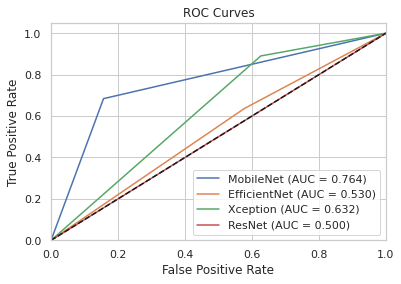

In [16]:
from sklearn.metrics import roc_curve

# Calculate ROC curve for each model
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(model_names)):
    fpr[i], tpr[i], _ = roc_curve(test_labels, predictions[i]) 
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure()
for i in range(len(model_names)):
    plt.plot(fpr[i], tpr[i], label=f'{model_names[i]} (AUC = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.show()

In [8]:
# Load the model
from keras.models import load_model
model = load_model("depthwise_separable_resnet_model.keras") 

# Load test image
import cv2
img_path = "Dataset/Test/Normal/Normal-(5).jpg" 
img = cv2.imread(img_path)
img = cv2.resize(img, (128, 128))
img = img.reshape(1, 128, 128, 3) 

# Make prediction
pred = model.predict(img)
print("Prediction Score:", pred[0][0])

# Interpret prediction
if pred > 0.85:
  print("Predicted Class: CKD") 
else:
  print("Predicted Class: Normal")

1/1 [==============================] - 1s 1s/step
Prediction Score: 0.82234484
Predicted Class: Normal
